Description: compendium of my annotations and studies from the book "Deep Learning with Python" from Francis Chollet, 2nd edition (2021).

### (3.5) Batch Linear Classifier


* The linear classifier will be basically an affine transformation $$ prediction = W*input + b$$ trained to minimize the square of difference between predictions and the targets. It will distinguish the two 'blobs' in the dataset.  Here $W=[[w_{1},w_{2}]]$ since the input is 2D, and $b$ is a scalar since in the classification problem we are only concerned with 0 and 1.
* Batch training (all data) is used instead of mini-batch training (small batches of data) in the training step. 
* The classifier is simply a 2D line given by $$ w_{1}*x+w_{2}*y+b = 0.5$$ for $[x,y]$ an input point 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

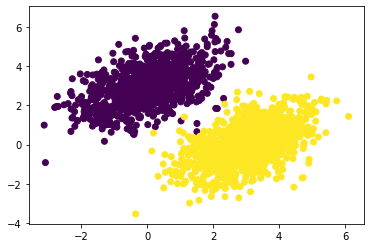

Loss at step 0: 1.1693
Loss at step 1: 0.2308
Loss at step 2: 0.1205
Loss at step 3: 0.1013
Loss at step 4: 0.0934
Loss at step 5: 0.0873
Loss at step 6: 0.0818
Loss at step 7: 0.0768
Loss at step 8: 0.0723
Loss at step 9: 0.0682
Loss at step 10: 0.0644
Loss at step 11: 0.0609
Loss at step 12: 0.0578
Loss at step 13: 0.0549
Loss at step 14: 0.0522
Loss at step 15: 0.0498
Loss at step 16: 0.0476
Loss at step 17: 0.0456
Loss at step 18: 0.0438
Loss at step 19: 0.0421
Loss at step 20: 0.0406
Loss at step 21: 0.0392
Loss at step 22: 0.0379
Loss at step 23: 0.0367
Loss at step 24: 0.0357
Loss at step 25: 0.0347
Loss at step 26: 0.0338
Loss at step 27: 0.0330
Loss at step 28: 0.0323
Loss at step 29: 0.0316
Loss at step 30: 0.0310
Loss at step 31: 0.0304
Loss at step 32: 0.0299
Loss at step 33: 0.0294
Loss at step 34: 0.0290
Loss at step 35: 0.0286
Loss at step 36: 0.0282
Loss at step 37: 0.0279
Loss at step 38: 0.0276
Loss at step 39: 0.0273


In [ ]:
num_samples_per_class = 1000
# Create two blobs with 1000 random 2D points
negative_samples = np.random.multivariate_normal(
mean=[0, 3],
cov=[[1, 0.5],[0.5, 1]],
size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
mean=[3, 0],
cov=[[1, 0.5],[0.5, 1]],
size=num_samples_per_class)

# Final matrix of size (2000,2)
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

# Labels: class 0 and 1 for distinguishing the two blobs
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
np.ones((num_samples_per_class, 1), dtype="float32")))

# Initial visualization of the data
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

# Linear Classifier variables
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

# fast foward pass function
def model(inputs):
  return tf.matmul(inputs, W) + b

# loss function
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions)
  return tf.reduce_mean(per_sample_losses)

# training procedure
learning_rate = 0.1 # for mini-batch training this is usually smaller

def training_step(input, targets): 
  with  tf.GradientTape() as tape:
    # forward pass inside the gradient tape scope
    predictions = model(inputs)
    loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W,b])
    W.assign_sub(grad_loss_wrt_W*learning_rate)
    b.assign_sub(grad_loss_wrt_b*learning_rate)
    return loss

for step in range(40):
  loss = training_step(inputs, targets)
  print(f"Loss at step {step}: {loss:.4f}")

predictions = model(inputs)



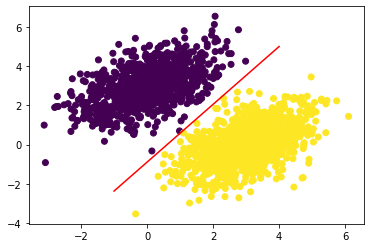

In [ ]:
x = np.linspace(-1,4,100)
y = -x*W[0]/W[1]+(0.5-b)/W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

Conclusion: The scratch implementation of the linear classifier is able to clearly separate both groups. One should be careful with the 'learning_rate'. Smaller or bigger values than 0.1 may lead to a bad classification.

# (4.1.1) IMDB dataset - Moview Review Classification

Description: binary classification problem - movie reviews as positive or negative via text content of reviews. Each sequence of words is translated to a sequence of integers. (Preprocessed data)

In [2]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
num_words=10000)

A reverse mapping would be fun! Let's take a look:

In [11]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join([reverse_word_index.get(i -3, "?") for i in train_data[1]])
print(decoded_review)
# The offset -3 to the indices reffer to the fact that "padding" - 0,
# "start of sequence" - 1, "unknown" - 2

1654784/1641221 [==============================] - 0s 0us/step
? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back 

Now we transform the list of integers into tensors. We'll use *Multi-hot encode*, and will choose a **Dense** layer (which is capable of handling floating-point vector data) in the first layer of the model.

In [3]:
import numpy as np

def vectorize_sequences(sequences,dimension=10000):
  results = np.zeros((len(sequences),dimension))
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1.
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Building the model:

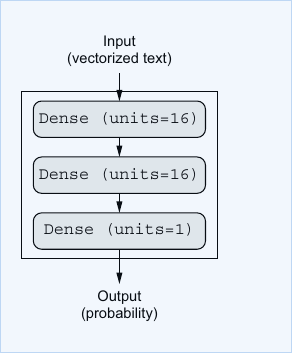


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
  layers.Dense(16,activation="relu"),
  layers.Dense(16,activation="relu"),
  layers.Dense(1,activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

The dimensionality of the representation space (16 in this case) represents "how much freedom you're allowing the model to have when learning internal representations". Allowing a large space may introduce more complex representations, although this may introduce unwanted patterns (that improves performance on the training data but not on the test data).

Loss: binari_crossentropy (cross entropy measures the distance between probability distributions, and it's usually a good option with output probabilities)

Optimizer: rmsprop

In [24]:
# Validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/20
30/30 [==============================] - 2s 41ms/step - loss: 0.5595 - accuracy: 0.7565 - val_loss: 0.4319 - val_accuracy: 0.8689
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.3471 - accuracy: 0.8947 - val_loss: 0.3302 - val_accuracy: 0.8782
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.2478 - accuracy: 0.9231 - val_loss: 0.2963 - val_accuracy: 0.8841
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1929 - accuracy: 0.9397 - val_loss: 0.2995 - val_accuracy: 0.8788
Epoch 5/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1565 - accuracy: 0.9511 - val_loss: 0.2791 - val_accuracy: 0.8887
Epoch 6/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1292 - accuracy: 0.9615 - val_loss: 0.2872 - val_accuracy: 0.8886
Epoch 7/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1061 - accuracy: 0.9688 - val_loss: 0.3058 - val_accuracy: 0.8831
Epoch 8/20
30

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

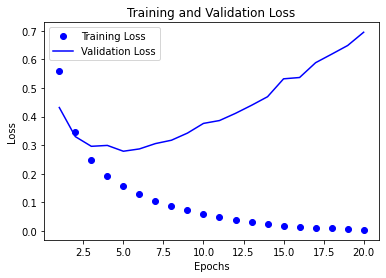

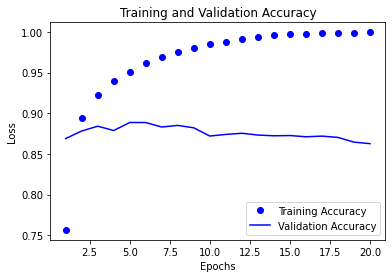

In [26]:
# Plotting the training and validation loss/accuracy
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1,len(loss_values)+1)
plt.plot(epochs, loss_values, "bo",label="Training Loss")
plt.plot(epochs,val_loss_values,"b", label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo",label="Training Accuracy")
plt.plot(epochs, val_acc,"b", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

We have a clear case of **overfitting**: after the fourth epoch, we’re overoptimizing on the training data, and we
end up learning representations that are specific to the training data and don’t gener-
alize to data outside of the training set.

Possible solution: analyze only for four epochs.

In [8]:
model = keras.Sequential([
  layers.Dense(16,activation="relu"),
  layers.Dense(16,activation="relu"),
  layers.Dense(1,activation="tanh")
])

model.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test,y_test)
print(results)
model.predict(x_test)

Epoch 1/4
49/49 [==============================] - 2s 22ms/step - loss: 0.1541 - accuracy: 0.7889
Epoch 2/4
49/49 [==============================] - 1s 18ms/step - loss: 0.0727 - accuracy: 0.9101
Epoch 3/4
49/49 [==============================] - 1s 18ms/step - loss: 0.0528 - accuracy: 0.9348
Epoch 4/4
782/782 [==============================] - 3s 3ms/step - loss: 0.0879 - accuracy: 0.8790
[0.08792798221111298, 0.879040002822876]


array([[0.18547922],
       [0.9996279 ],
       [0.91573197],
       ...,
       [0.1532966 ],
       [0.10080991],
       [0.533819  ]], dtype=float32)

We have an accuracy of 88%, and loss of 29%. Chollet's points out that state-of-the-art approaches can get close to 95% of accuracy.

List of possible exercises:



1.   Different number of representation layers; How does it affect validation and test accuracy?
2.   More units in layers? 32, 64...
3.   *binary_crossentropy* -> *mse* loss.
4.   *relu* -> *tanh* activation. 





Answers:


1.   One, or three representation layers does not change the results significantly.
2.   //;
3.  Significant decrease of loss from 0.29 to 0.07 while maintaining the accuracy at 0.88.
4.   No significant change.


# (4.2) Single-label multiclass classification

Description: model to classify Reuters newswires into 46 mutually exclusive topics.